In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/Users/anita/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


/var/folders/z4/71b6tmrx0734808cd1m9h1qh0000gn/T/ipykernel_29165/1780131873.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y, palette='coolwarm')


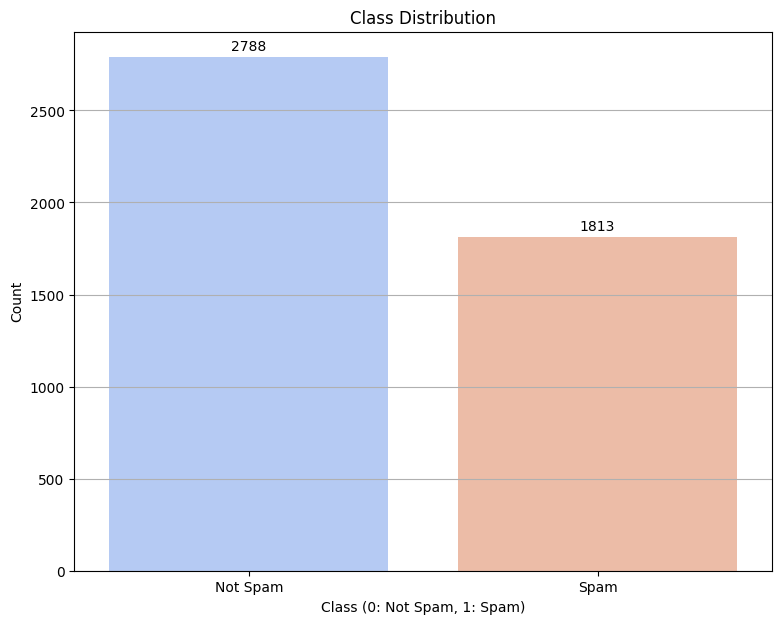

In [2]:
# Step 1: Load Raw Local Dataset
with open('spambase.names', 'r') as file:
    lines = file.readlines()
feature_names = [line.split(':')[0] for line in lines if ':' in line]

data = pd.read_csv('spambase.data', header=None)
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels (Spam=1, Not Spam=0)

# Plot class distribution
plt.figure(figsize=(9, 7))
ax = sns.countplot(x=y, palette='coolwarm')
class_counts = pd.Series(y).value_counts()
plt.title("Class Distribution")
plt.xlabel("Class (0: Not Spam, 1: Spam)")
plt.ylabel("Count")
plt.xticks([0, 1], ["Not Spam", "Spam"])
plt.grid(axis='y')
for p, count in zip(ax.patches, class_counts.sort_index().values):
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.show()

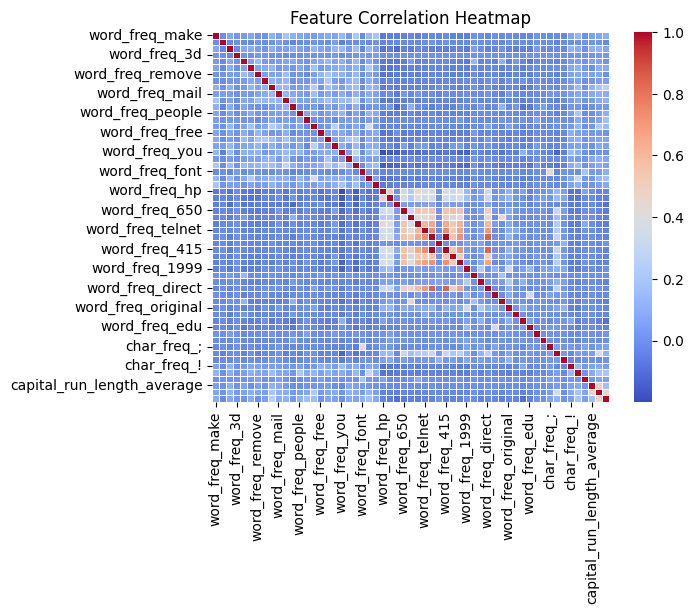

In [3]:
# Step 2: Data Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert features to DataFrame for correlation calculation
# Correctly parse feature names from spambase.names
feature_names = []
with open('spambase.names', 'r') as f:
    for line in f:
        if ':' in line:  # Only process lines with actual feature definitions
            feature_name = line.split(':')[0].strip()  # Extract feature name
            if feature_name != '| UCI Machine Learning Repository':
                feature_names.append(feature_name)

# Add the class label manually (spam or not spam)
feature_names.append("class")
df_features = pd.DataFrame(X_scaled, columns=feature_names[:-1])
# Calculate and plot correlation heatmap
correlation_matrix = df_features.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


Number of features selected by Lasso: 55


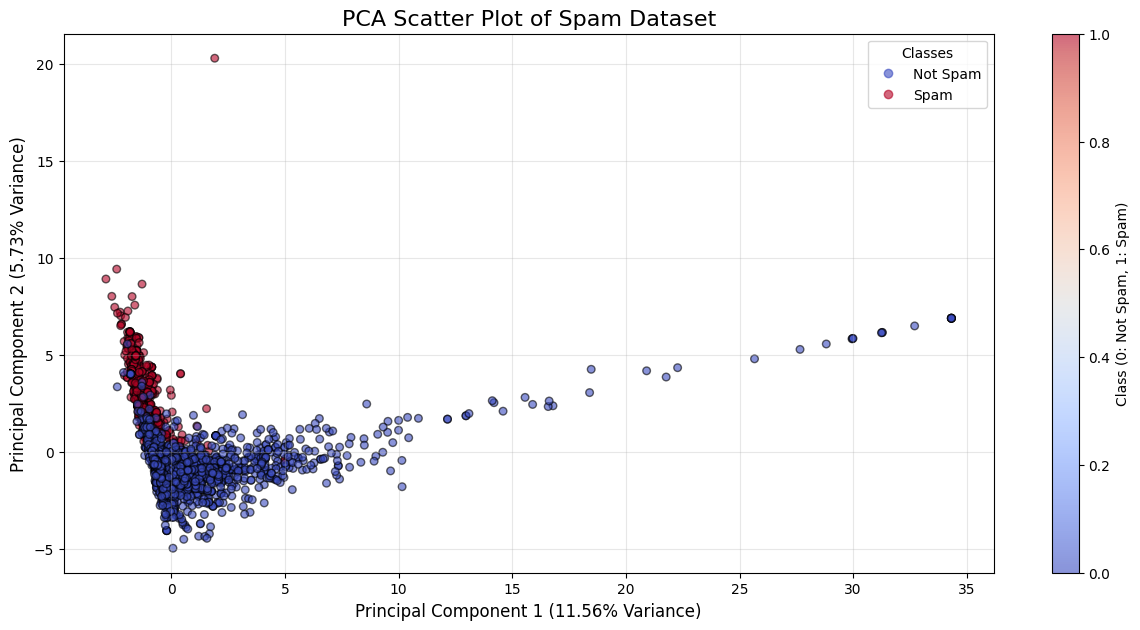

In [4]:
# Step 3: Feature Selection
# Lasso for feature selection
lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y)
selected_features = np.where(lasso.coef_ != 0)[0]
X_lasso = X_scaled[:, selected_features]
print(f"Number of features selected by Lasso: {len(selected_features)}")
# PCA for dimensionality reduction and visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
# PCA visualization
plt.figure(figsize=(15, 7))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolor='k', s=30
)
explained_variance = pca.explained_variance_ratio_ * 100
plt.title("PCA Scatter Plot of Spam Dataset", fontsize=16)
plt.xlabel(f"Principal Component 1 ({explained_variance[0]:.2f}% Variance)", fontsize=12)
plt.ylabel(f"Principal Component 2 ({explained_variance[1]:.2f}% Variance)", fontsize=12)
plt.colorbar(scatter, label='Class (0: Not Spam, 1: Spam)')
plt.grid(alpha=0.3)
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=["Not Spam", "Spam"],
    title="Classes",
    loc='upper right',
    fontsize=10
)

plt.show()

In [5]:
def training_model(size):
    print(f'test size = ', {size})
    # Step 4: Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=size, stratify=y, random_state=42)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Step 5: Train 4 Models
    # Initialize dictionaries to store results
    results_without_cv = {}
    results_with_cv = {}

    # Models to evaluate
    models = {
        "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
        "Gaussian Discriminant Analysis": QuadraticDiscriminantAnalysis(),
        "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
        "Support Vector Machine": SVC(probability=True, random_state=42)
    }
    decision_boundary_models = ["Logistic Regression", "Gaussian Discriminant Analysis", "Random Forest", "Support Vector Machine"]

    # Without Cross-Validation
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        loss = log_loss(y_test, model.predict_proba(X_test))
        results_without_cv[name] = {"Accuracy": accuracy, "Log Loss": loss}
        print(f"Without CV - {name}: Accuracy = {accuracy:.2f}, Log Loss = {loss:.4f}")

    #  Step 6: With Cross-Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for name, model in models.items():
        # Cross-validated accuracy
        cv_accuracy = cross_val_score(model, X_scaled, y, cv=cv, scoring="accuracy").mean()

        # Cross-validated log loss
        y_pred_proba_cv = cross_val_predict(model, X_scaled, y, cv=cv, method="predict_proba")
        cv_log_loss = log_loss(y, y_pred_proba_cv)

        results_with_cv[name] = {"CV Accuracy": cv_accuracy, "CV Log Loss": cv_log_loss}
        print(f"With CV - {name}: Cross-Validated Accuracy = {cv_accuracy:.2f}, Cross-Validated Log Loss = {cv_log_loss:.4f}")

    # Convert results to DataFrame for visualization
    df_without_cv = pd.DataFrame(results_without_cv).T
    df_with_cv = pd.DataFrame(results_with_cv).T
    
    # Combine results into a single DataFrame
    combined_df = pd.concat([df_without_cv, df_with_cv], axis=1, keys=["Without CV", "With CV"])
    combined_df.columns = combined_df.columns.map('_'.join)  # Flatten the multi-index

    # Visualization: Combine into one plot
    fig, ax = plt.subplots(figsize=(14, 8))
    bar_width = 0.2  # Adjust width to fit all columns
    x = np.arange(len(combined_df.index))  # Bar positions

    # Plot bars for Accuracy and Log Loss with distinct colors and alpha
    ax.bar(x - bar_width * 1.5, combined_df["Without CV_Accuracy"], bar_width, 
           label="Accuracy (No CV)", color="red", alpha=0.45)
    ax.bar(x - bar_width * 0.5, combined_df["With CV_CV Accuracy"], bar_width, 
           label="Accuracy (CV)", color="red", alpha=0.7)
    ax.bar(x + bar_width * 0.5, combined_df["Without CV_Log Loss"], bar_width, 
           label="Log Loss (No CV)", color="blue", alpha=0.45)
    ax.bar(x + bar_width * 1.5, combined_df["With CV_CV Log Loss"], bar_width, 
           label="Log Loss (CV)", color="blue", alpha=0.7)

    # Add labels, title, and legend
    ax.set_title(f"Model Performance(test_size = {size}): With and Without Cross-Validation", fontsize=16, fontweight='bold')
    ax.set_xlabel("Models", fontsize=14)
    ax.set_ylabel("Score", fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(combined_df.index, fontsize=12)
    ax.legend(loc="best", fontsize=12)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    # Add annotations for clarity
    for i, row in combined_df.iterrows():
        ax.text(x[np.where(combined_df.index == i)][0] - bar_width * 1.5, row["Without CV_Accuracy"] + 0.01, 
                f'{row["Without CV_Accuracy"]:.2f}', ha='center', color='black', fontsize=9)
        ax.text(x[np.where(combined_df.index == i)][0] - bar_width * 0.5, row["With CV_CV Accuracy"] + 0.01, 
                f'{row["With CV_CV Accuracy"]:.2f}', ha='center', color='black', fontsize=9)
        ax.text(x[np.where(combined_df.index == i)][0] + bar_width * 0.5, row["Without CV_Log Loss"] + 0.01, 
                f'{row["Without CV_Log Loss"]:.2f}', ha='center', color='black', fontsize=9)
        ax.text(x[np.where(combined_df.index == i)][0] + bar_width * 1.5, row["With CV_CV Log Loss"] + 0.01, 
                f'{row["With CV_CV Log Loss"]:.2f}', ha='center', color='black', fontsize=9)

    plt.show()

    # Confusion Matrix for the Best Model (Random Forest as an example)
    best_model = models["Random Forest"]
    y_pred_best = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_best)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", 
            xticklabels=["Not Spam", "Spam"], 
            yticklabels=["Not Spam", "Spam"], 
            annot_kws={"size": 12})  # Adjust font size for annotations
    plt.title(f"Confusion Matrix - Random Forest(test_size = {size})")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    # Step 7: Individual Decision Boundary Plots
    def plot_decision_boundary(X, y, model, title):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                            np.arange(y_min, y_max, 0.01))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='coolwarm', alpha=0.6)
        plt.title(title)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid()

    def plot_blank_pca_with_scale(X, y, x_min, x_max, y_min, y_max, title="PCA Plot Without Boundaries"):
        plt.figure(figsize=(8, 6))
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='coolwarm', alpha=0.6)
        plt.title(title, fontsize=14)
        plt.xlabel("Principal Component 1", fontsize=12)
        plt.ylabel("Principal Component 2", fontsize=12)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.grid(alpha=0.3)
        plt.show()
        
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1

    # Plotting the blank PCA plot with the same scale
    plot_blank_pca_with_scale(X_pca, y, x_min, x_max, y_min, y_max, title="PCA Plot")
    
    # Visualize Decision Boundaries
    for name in decision_boundary_models:
        plt.figure(figsize=(8, 6))
        model = models[name]
        # Train the model on PCA-reduced data
        model.fit(X_train_pca, y_train)
        # Plot decision boundary using PCA-reduced training data
        plot_decision_boundary(X_train_pca, y_train, model, f"{name} Decision Boundary (PCA with test_size = {size})")
        plt.show()


test size =  {0.1}
Without CV - Logistic Regression: Accuracy = 0.91, Log Loss = 0.2855
Without CV - Gaussian Discriminant Analysis: Accuracy = 0.82, Log Loss = 4.8998
Without CV - Random Forest: Accuracy = 0.95, Log Loss = 0.1565
Without CV - Support Vector Machine: Accuracy = 0.92, Log Loss = 0.2864
With CV - Logistic Regression: Cross-Validated Accuracy = 0.93, Cross-Validated Log Loss = 0.2392
With CV - Gaussian Discriminant Analysis: Cross-Validated Accuracy = 0.82, Cross-Validated Log Loss = 5.0895


/Users/anita/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/anita/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/anita/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/anita/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


With CV - Random Forest: Cross-Validated Accuracy = 0.95, Cross-Validated Log Loss = 0.1875
With CV - Support Vector Machine: Cross-Validated Accuracy = 0.93, Cross-Validated Log Loss = 0.2026


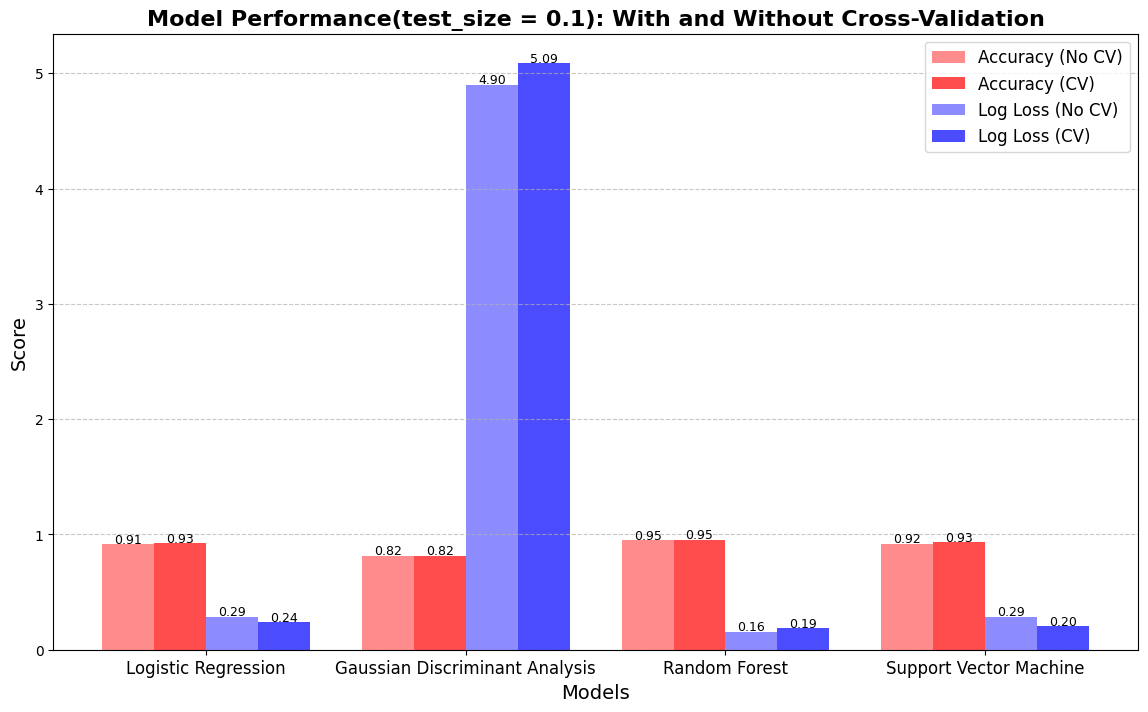

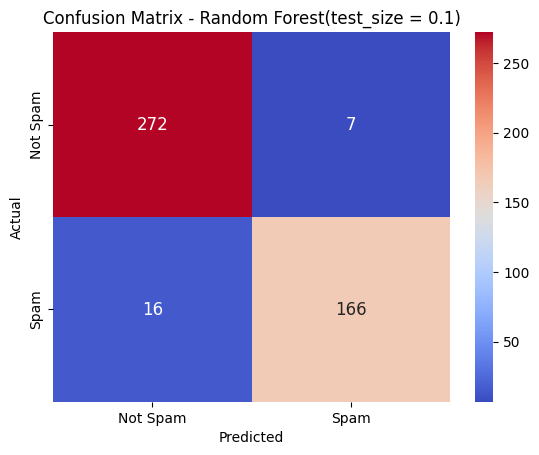

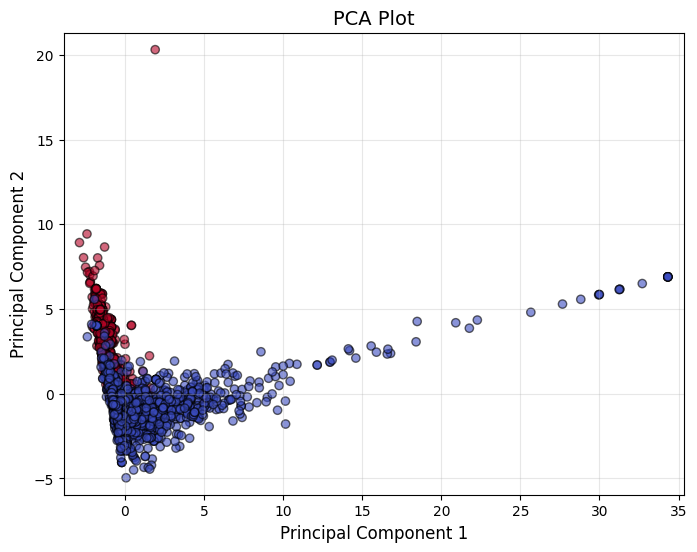

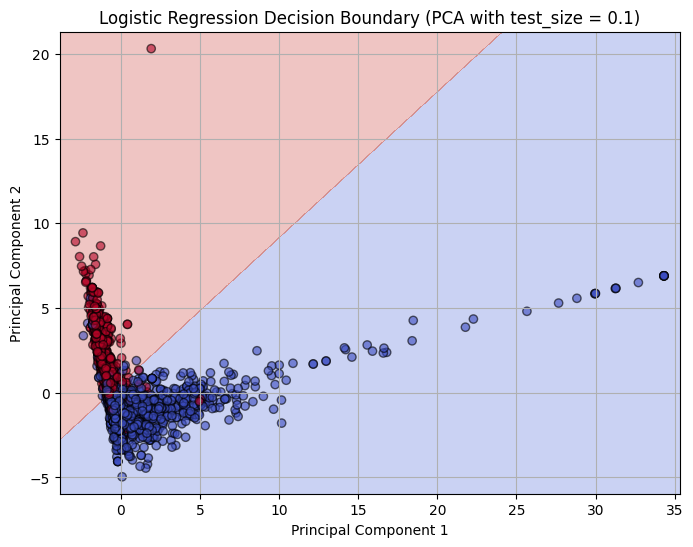

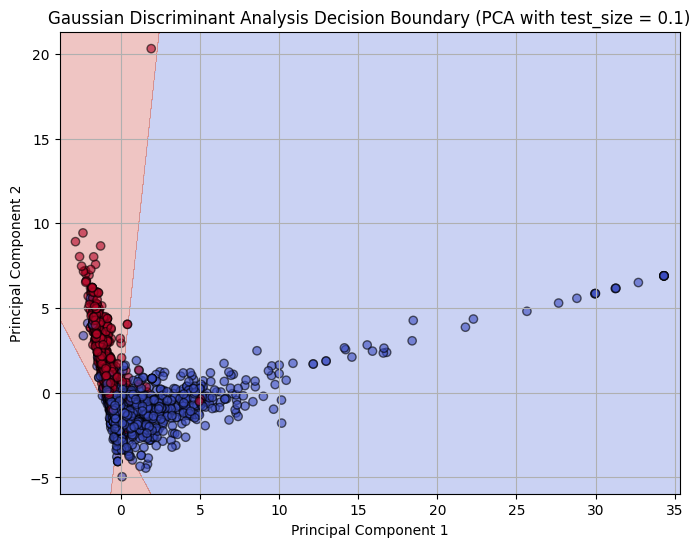

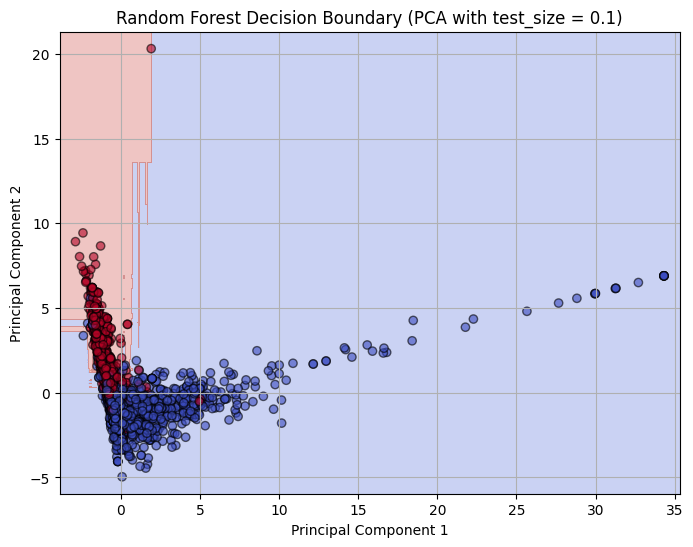

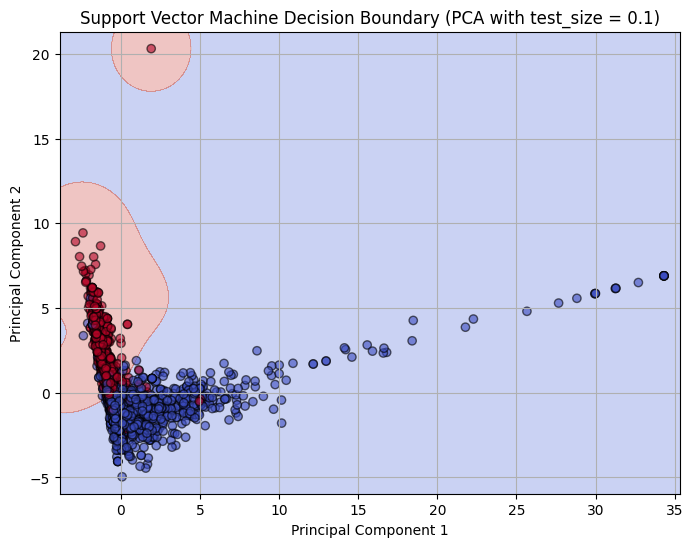

test size =  {0.2}
Without CV - Logistic Regression: Accuracy = 0.93, Log Loss = 0.2336
Without CV - Gaussian Discriminant Analysis: Accuracy = 0.84, Log Loss = 3.9585
Without CV - Random Forest: Accuracy = 0.94, Log Loss = 0.2322
Without CV - Support Vector Machine: Accuracy = 0.93, Log Loss = 0.2290
With CV - Logistic Regression: Cross-Validated Accuracy = 0.93, Cross-Validated Log Loss = 0.2392
With CV - Gaussian Discriminant Analysis: Cross-Validated Accuracy = 0.82, Cross-Validated Log Loss = 5.0895


/Users/anita/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/anita/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/anita/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/anita/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


With CV - Random Forest: Cross-Validated Accuracy = 0.95, Cross-Validated Log Loss = 0.1875
With CV - Support Vector Machine: Cross-Validated Accuracy = 0.93, Cross-Validated Log Loss = 0.2026


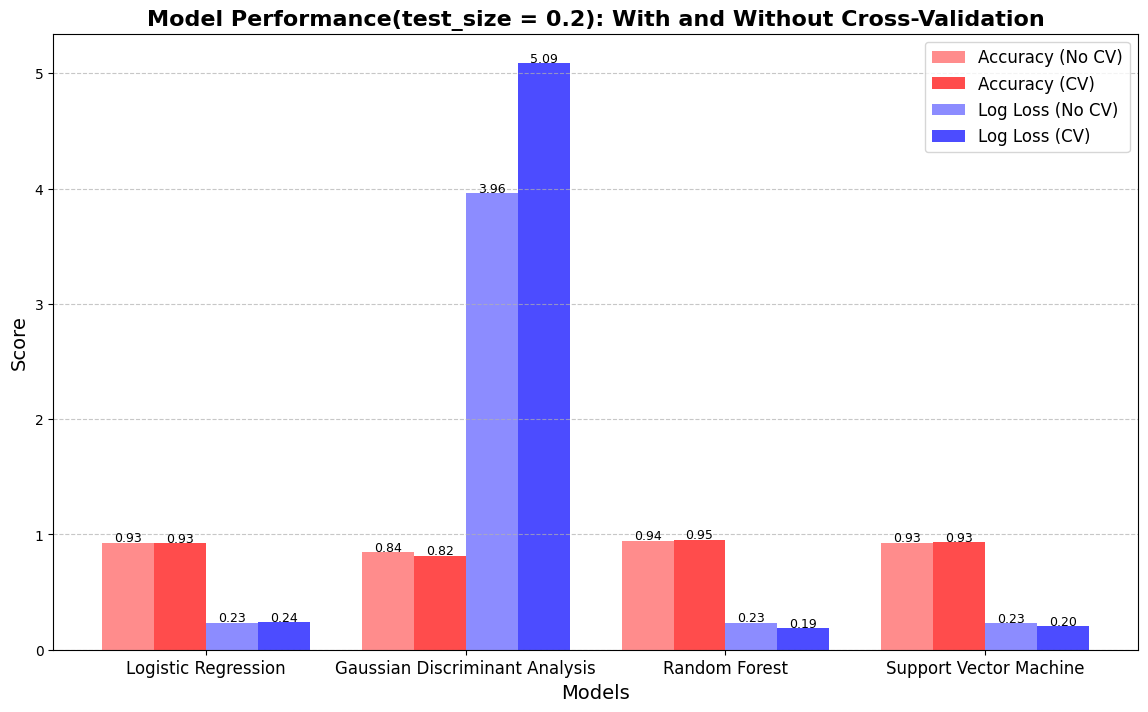

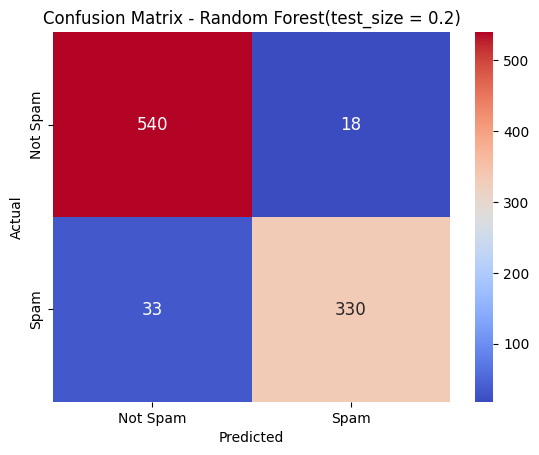

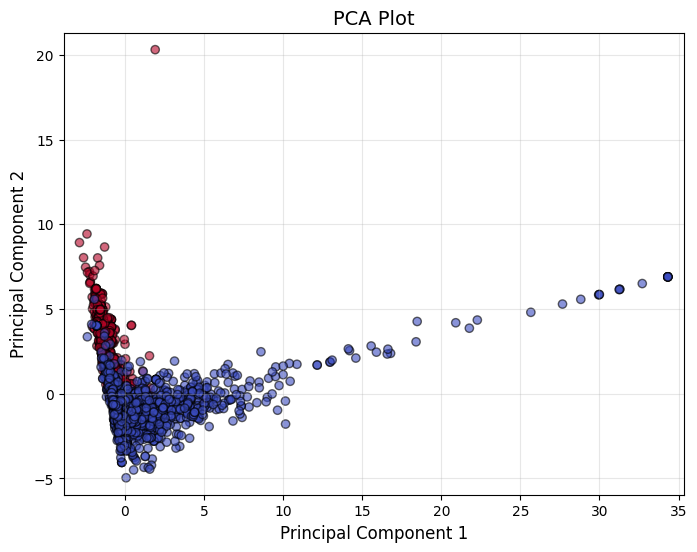

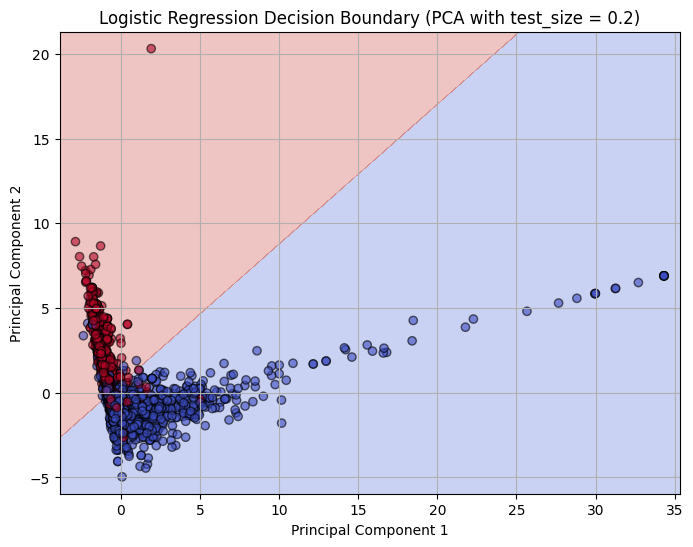

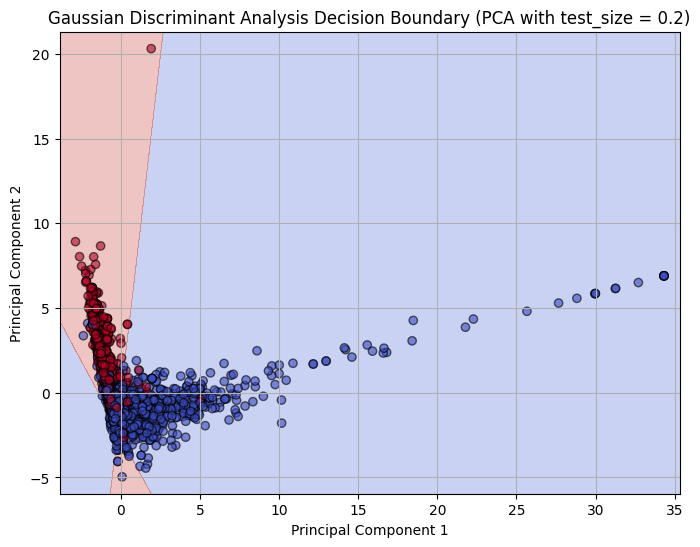

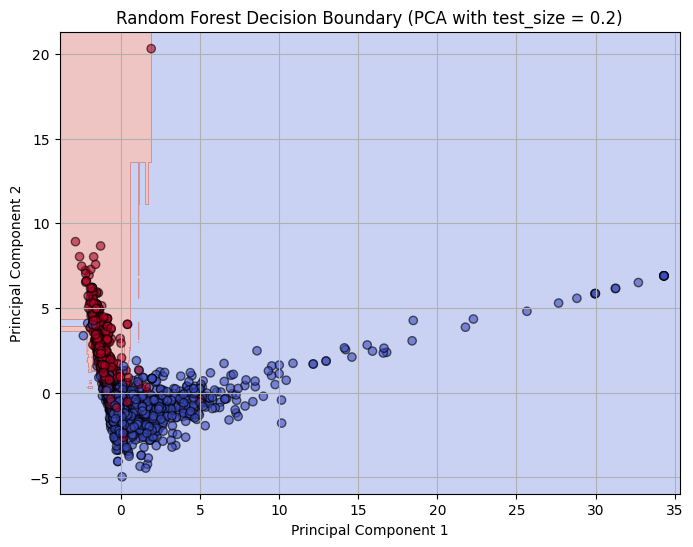

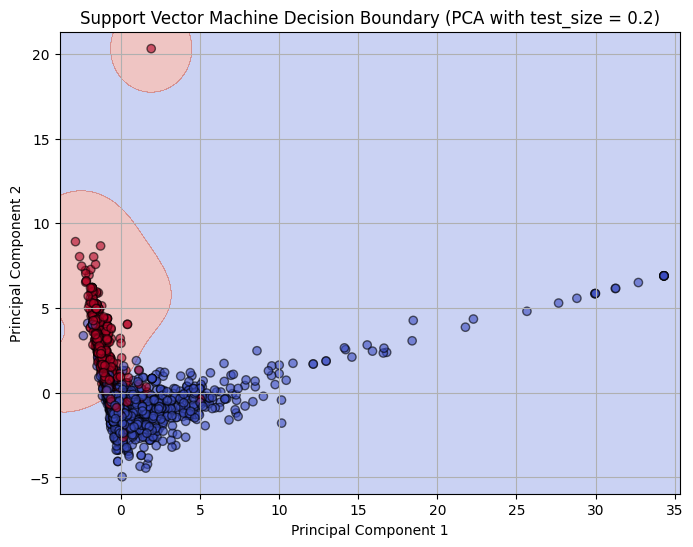

test size =  {0.3}
Without CV - Logistic Regression: Accuracy = 0.93, Log Loss = 0.2249
Without CV - Gaussian Discriminant Analysis: Accuracy = 0.83, Log Loss = 4.1217
Without CV - Random Forest: Accuracy = 0.96, Log Loss = 0.2258
Without CV - Support Vector Machine: Accuracy = 0.93, Log Loss = 0.2072
With CV - Logistic Regression: Cross-Validated Accuracy = 0.93, Cross-Validated Log Loss = 0.2392
With CV - Gaussian Discriminant Analysis: Cross-Validated Accuracy = 0.82, Cross-Validated Log Loss = 5.0895


/Users/anita/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/anita/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/anita/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/anita/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


With CV - Random Forest: Cross-Validated Accuracy = 0.95, Cross-Validated Log Loss = 0.1875
With CV - Support Vector Machine: Cross-Validated Accuracy = 0.93, Cross-Validated Log Loss = 0.2026


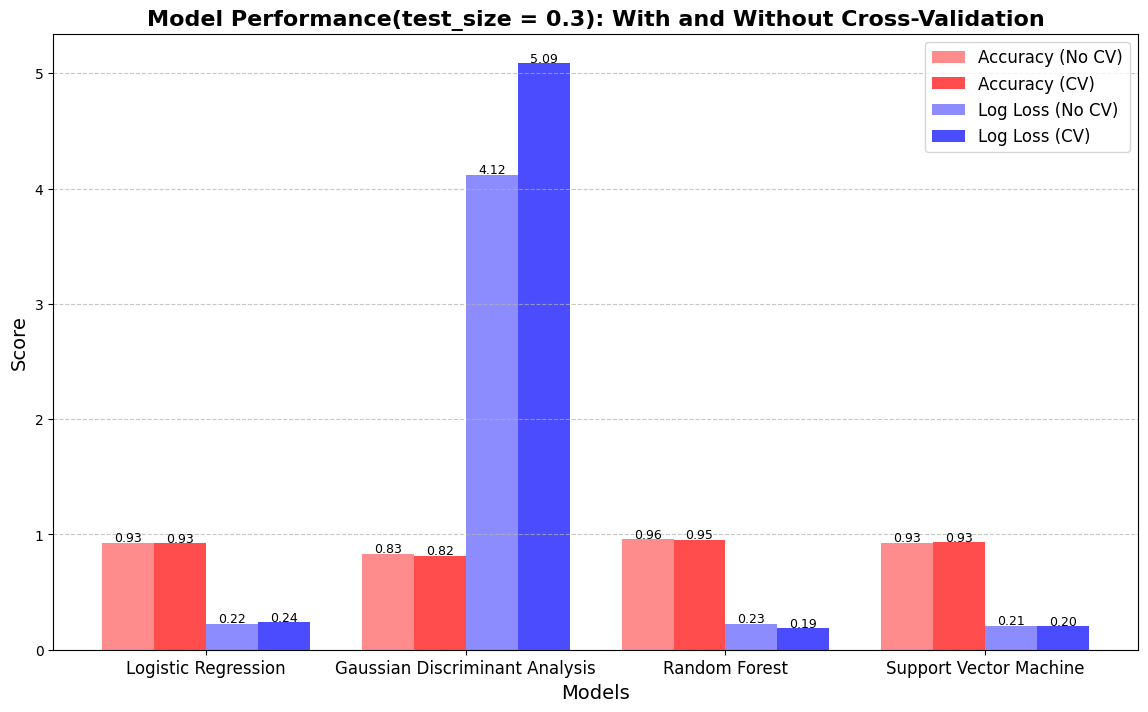

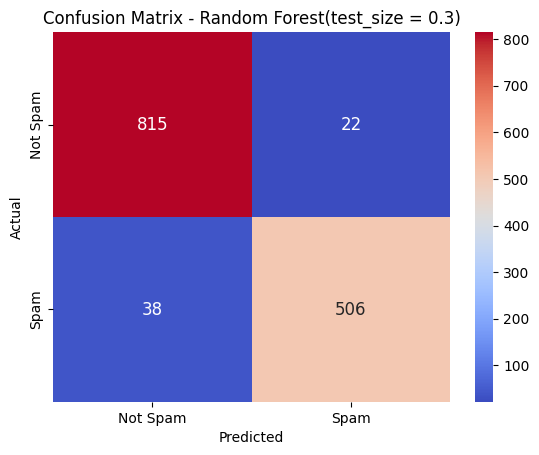

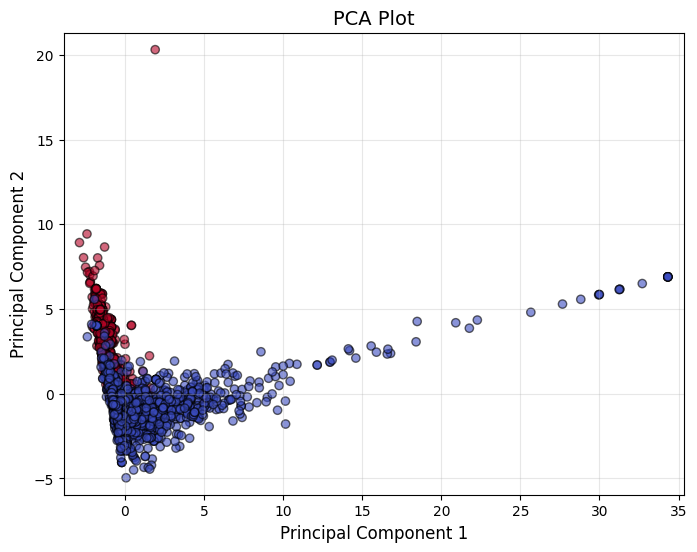

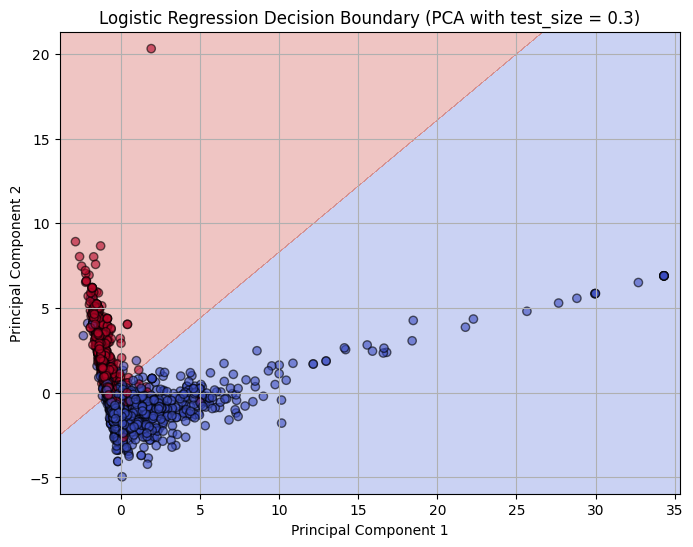

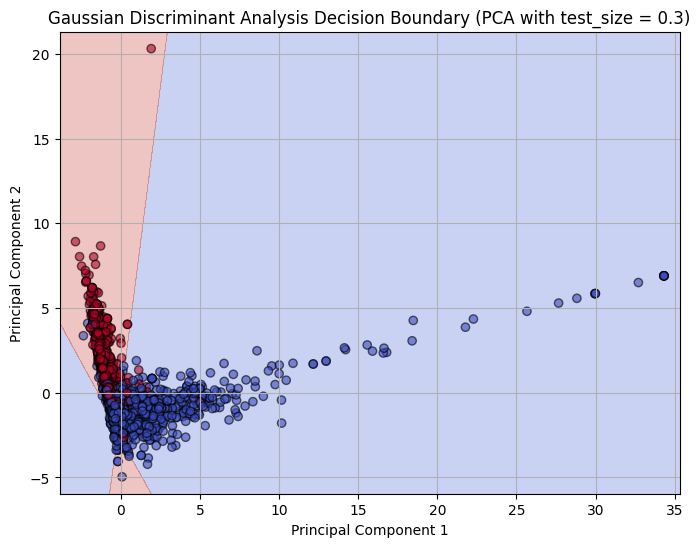

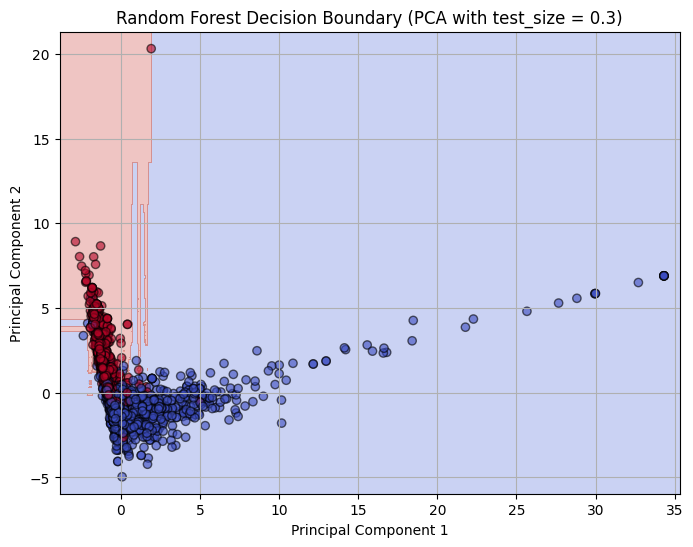

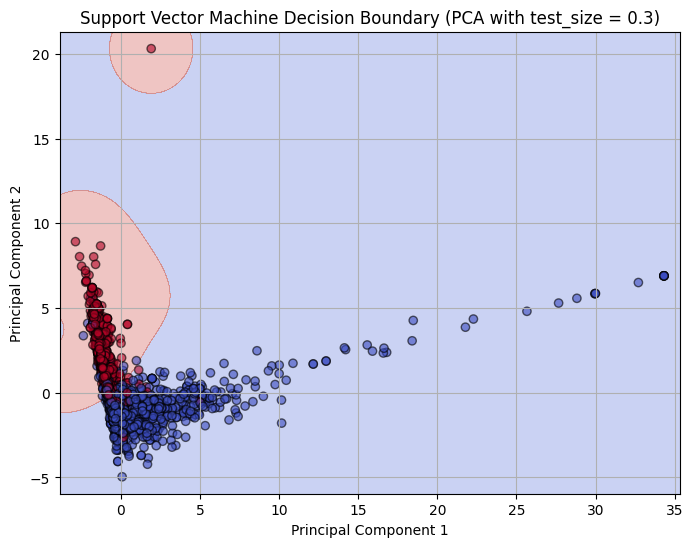

In [6]:
training_size = [0.1, 0.2 ,0.3]
for size in training_size:
    training_model(size)